# Neural Network Experiment Notebook

### Objectives
- Build a feedforward neural network from scratch using NumPy.
- Support different label encodings: **One-hot** (10 outputs) and **Bit-4** (binary representation with 4 outputs).
- Train the models using stochastic gradient descent with different activation and loss functions.
- Evaluate model performance on training, validation, and test sets.
- Apply adversarial attack methods (e.g., **FGSM**) to test the robustness of trained models.

### Structure of this notebook
1. **Imports** – load required libraries and helper functions.
2. **Layer class** – implement a single fully connected layer with activations.
3. **MLPModel class** – define the multi-layer perceptron with training and evaluation methods.
4. **Data loading** – load and preprocess MNIST data.
5. **Experiment runner** – run training experiments with given settings.
6. **One-hot main block** – train and save model with one-hot labels.
7. **Bit-4 main block** – train and save model with bit-4 labels.
8. **Attack block** – perform adversarial attacks and evaluate robustness.

This notebook helps to better understand the training process, compare encoding strategies, and analyze adversarial robustness.


## Imports

This section imports required libraries and helper modules.

In [1]:
import gzip
import pickle
import numpy as np
from Visualization import *
from Functions import *

## Layer class

Implementation of a fully connected neural network layer with different activation functions.

In [3]:
class layer():
    def __init__(self, n_input, n_output, activation=None):
        self.W = np.random.randn(n_input, n_output) / np.sqrt(n_input)
        self.b = np.zeros((1, n_output))
        self.activation = activation
        self.input = None
        self.output = None

    def forward(self, input):
        z = np.dot(input, self.W) + self.b
        if self.activation == 'sigmoid':
            self.output = sigmoid(z)
        elif self.activation == 'ReLU':
            self.output = ReLU(z)
        elif self.activation == 'tanh':
            self.output = tanh(z)
        elif self.activation == 'softmax':
            self.output = softmax(z)
        else:
            self.output = z
        self.input = input
        return self.output

    def backward(self, output_grad):
        if self.activation == 'sigmoid':
            output_grad = output_grad * sigmoid_derivative(self.output)
        elif self.activation == 'ReLU':
            output_grad = output_grad * ReLU_derivative(self.output)
        elif self.activation == 'tanh':
            output_grad = output_grad * tanh_derivative(self.output)
        self.W_grad = np.dot(self.input.T, output_grad)
        self.b_grad = np.sum(output_grad, axis=0, keepdims=True)
        return np.dot(output_grad, self.W.T)

## MLPModel class

Implementation of a multi-layer perceptron model that supports training, evaluation, and prediction.

In [4]:
class MLPModel():
    def __init__(self, input_size, output_size, hidden_sizes, num_layers, activations, loss="mse"):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes
        self.num_layers = num_layers
        self.activations = activations
        self.layers = []
        self.loss = loss
        self.train_losses = []
        self.val_losses = []
        self.init_weights()

    def init_weights(self):
        if self.num_layers == 0:
            self.layers.append(layer(self.input_size, self.output_size, self.activations[0]))
        else:
            self.layers.append(layer(self.input_size, self.hidden_sizes[0], self.activations[0]))
            for i in range(1, self.num_layers):
                self.layers.append(layer(self.hidden_sizes[i-1], self.hidden_sizes[i], self.activations[i]))
            self.layers.append(layer(self.hidden_sizes[-1], self.output_size, self.activations[-1]))

    def forward(self, X):
        out = X
        for l in self.layers:
            out = l.forward(out)
        return out

    def backward(self, y, y_hat):
        if self.loss == "mse":
            grad = mse_derivative(y, y_hat)
        elif self.loss == "cross_entropy":
            grad = cross_entropy_derivative(y, y_hat)
        elif self.loss == "bce_logits":
            grad = bce_logits_derivative(y, y_hat)
        else:
            raise ValueError("Unsupported loss function")
        for l in reversed(self.layers):
            grad = l.backward(grad)

    def update(self, lr):
        for l in self.layers:
            l.W -= lr * l.W_grad
            l.b -= lr * l.b_grad

    def fit(self, X, y, X_val, y_val, epochs, lr, batch_size, verbose=1):
        for epoch in range(epochs):
            idx = np.random.permutation(X.shape[0])
            X, y = X[idx], y[idx]

            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                y_hat = self.forward(X_batch)
                self.backward(y_batch, y_hat)
                self.update(lr)

            y_hat_train = self.forward(X)
            y_hat_val = self.forward(X_val)
            if self.loss == "mse":
                train_loss = mse(y, y_hat_train)
                val_loss = mse(y_val, y_hat_val)
            elif self.loss == "cross_entropy":
                train_loss = cross_entropy(y, y_hat_train)
                val_loss = cross_entropy(y_val, y_hat_val)
            elif self.loss == "bce_logits":
                train_loss = bce_logits(y, y_hat_train)
                val_loss = bce_logits(y_val, y_hat_val)
            else:
                raise ValueError("Unsupported loss")
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            train_acc = self.evaluate(X, y)
            val_acc = self.evaluate(X_val, y_val)
            if verbose:
                print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

    def predict(self, X):
        y_hat = self.forward(X)
        return np.argmax(y_hat, axis=1)

    def evaluate(self, X, y):
        y_hat = self.forward(X)
        if y.shape[1] == 4:
            y_pred = bit4_logits_to_int(y_hat)
            y_true = bit4_bits_to_int(y)
        else: 
            y_pred = np.argmax(y_hat, axis=1)
            y_true = np.argmax(y, axis=1)
        return np.mean(y_pred == y_true)

## Data loading

Function to load the MNIST dataset and encode labels as one-hot or bit-4.

In [5]:
def load_mnist(path='mnist.pkl.gz', label_mode='onehot'):
    with gzip.open(path, 'rb') as f:
        train_set, val_set, test_set = pickle.load(f, encoding='latin1')
    X_train, y_train = train_set
    X_val, y_val = val_set
    X_test, y_test = test_set
    if label_mode == 'onehot':
        y_train = np.eye(10)[y_train]
        y_val = np.eye(10)[y_val]
        y_test = np.eye(10)[y_test]
    elif label_mode == 'bit4':
        y_train = to_bit4(y_train)
        y_val = to_bit4(y_val)
        y_test = to_bit4(y_test)
    else:
        raise ValueError("label_mode must be 'onehot' or 'bit4'")
    return X_train, y_train, X_val, y_val, X_test, y_test

## Experiment runner

Helper function to train and evaluate the MLP with given parameters.

In [8]:
def run_experiment(
        label_mode='onehot', 
        layers = [784, 30, 10],
        activations = ['sigmoid', 'sigmoid'],
        loss = 'mse',
        epochs=10, lr=0.5, batch_size=10, seed=42, verbose=1
        ):
    np.random.seed(seed)
    X_train, y_train, X_val, y_val, X_test, y_test = load_mnist('mnist.pkl.gz', label_mode=label_mode)
    model = MLPModel(layers[0], layers[-1], layers[1:-1], len(layers)-2, activations, loss=loss)
    model.fit(X_train, y_train, X_val, y_val, epochs=epochs, lr=lr, batch_size=batch_size, verbose=verbose)
    test_acc = model.evaluate(X_test, y_test)
    return {
        'label_mode': label_mode,
        'test_acc': float(test_acc),
        'train_losses': model.train_losses,
        'val_losses': model.val_losses,
        'model': model,
        'X_test': X_test,
        'y_test': y_test,
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val
    }

## One-hot main block

Train and save the model using one-hot encoded labels.

Epoch 1: Train Acc=0.9390, Val Acc=0.9398, Train Loss=0.0509, Val Loss=0.0498
Epoch 2: Train Acc=0.9449, Val Acc=0.9432, Train Loss=0.0478, Val Loss=0.0490
Epoch 3: Train Acc=0.9493, Val Acc=0.9453, Train Loss=0.0435, Val Loss=0.0463
Epoch 4: Train Acc=0.9540, Val Acc=0.9517, Train Loss=0.0400, Val Loss=0.0422
Epoch 5: Train Acc=0.9533, Val Acc=0.9490, Train Loss=0.0401, Val Loss=0.0436
Epoch 6: Train Acc=0.9585, Val Acc=0.9536, Train Loss=0.0366, Val Loss=0.0409
Epoch 7: Train Acc=0.9629, Val Acc=0.9517, Train Loss=0.0333, Val Loss=0.0410
Epoch 8: Train Acc=0.9625, Val Acc=0.9524, Train Loss=0.0335, Val Loss=0.0399
Epoch 9: Train Acc=0.9617, Val Acc=0.9547, Train Loss=0.0329, Val Loss=0.0391
Epoch 10: Train Acc=0.9627, Val Acc=0.9554, Train Loss=0.0331, Val Loss=0.0400
Model saved: trained_mnist_model.pkl
One-hot Test Acc: 0.9469


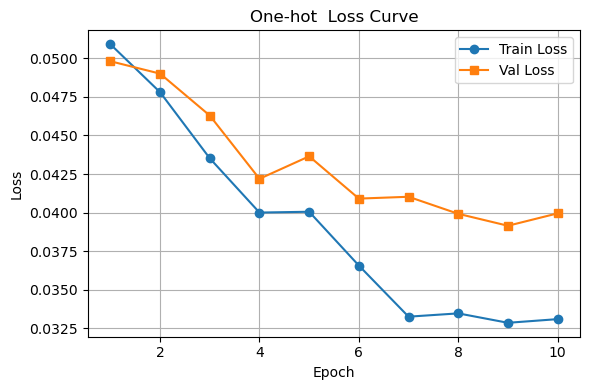

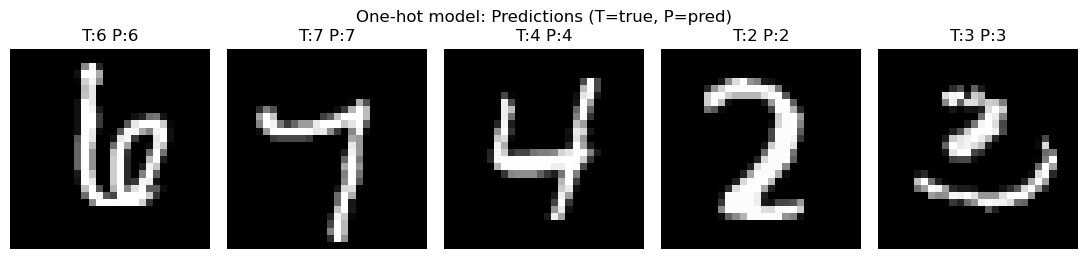

In [9]:
# One-hot training and plotting
set_seed(42)
res_onehot = run_experiment()  # default settings
with open('trained_mnist_model.pkl', 'wb') as f:
    pickle.dump(res_onehot['model'], f)
print("Model saved: trained_mnist_model.pkl")
print(f"One-hot Test Acc: {res_onehot['test_acc']:.4f}")

# Plot loss curves comparing one-hot
plot_loss_curve(res_onehot, save_path="loss_curve_onehot.png", title_prefix="One-hot")


# Plot prediction grid for one-hot model (images + true/pred labels)
plot_predictions_grid(res_onehot['model'], res_onehot['X_test'], res_onehot['y_test'],
                      mode_title='One-hot model', n=5,
                      save_path='predictions_onehot.png')


## Bit-4 main block

Train and save the model using bit-4 encoded labels.

Epoch 1: Train Acc=0.6579, Val Acc=0.6695, Train Loss=0.3319, Val Loss=0.3232
Epoch 2: Train Acc=0.7053, Val Acc=0.7134, Train Loss=0.2948, Val Loss=0.2913
Epoch 3: Train Acc=0.8200, Val Acc=0.8333, Train Loss=0.2367, Val Loss=0.2316


d:\LU Documents\course\Advanced Course in Numerical Algorithms with PythonSciPy\project1\Functions.py:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 4: Train Acc=0.6787, Val Acc=0.6870, Train Loss=0.3130, Val Loss=0.3167
Epoch 5: Train Acc=0.8417, Val Acc=0.8522, Train Loss=0.2199, Val Loss=0.2106
Epoch 6: Train Acc=0.7925, Val Acc=0.8127, Train Loss=0.2385, Val Loss=0.2215
Epoch 7: Train Acc=0.8241, Val Acc=0.8363, Train Loss=0.2175, Val Loss=0.2163
Epoch 8: Train Acc=0.8598, Val Acc=0.8658, Train Loss=0.1844, Val Loss=0.1841
Epoch 9: Train Acc=0.8599, Val Acc=0.8684, Train Loss=0.1849, Val Loss=0.1852
Epoch 10: Train Acc=0.8708, Val Acc=0.8810, Train Loss=0.1664, Val Loss=0.1659
Epoch 11: Train Acc=0.8446, Val Acc=0.8543, Train Loss=0.1985, Val Loss=0.1991
Epoch 12: Train Acc=0.8722, Val Acc=0.8817, Train Loss=0.1672, Val Loss=0.1676
Epoch 13: Train Acc=0.8546, Val Acc=0.8645, Train Loss=0.1819, Val Loss=0.1747
Epoch 14: Train Acc=0.8299, Val Acc=0.8412, Train Loss=0.2010, Val Loss=0.1997
Epoch 15: Train Acc=0.8702, Val Acc=0.8798, Train Loss=0.1728, Val Loss=0.1682
Model saved: trained_mnist_model_bit4.pkl
Bit-4 Test Acc: 

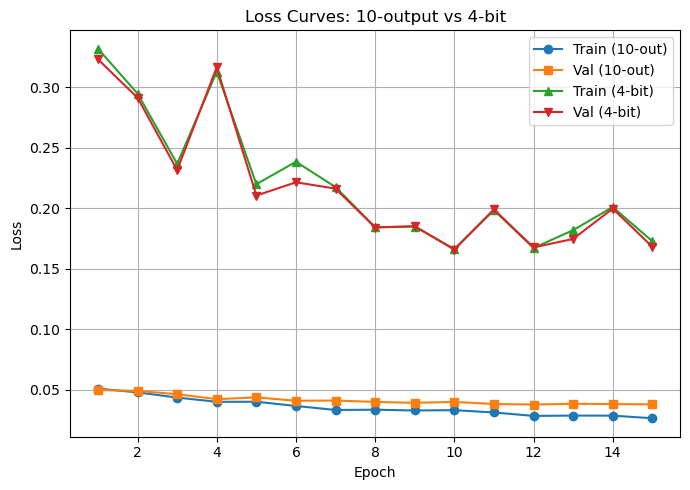

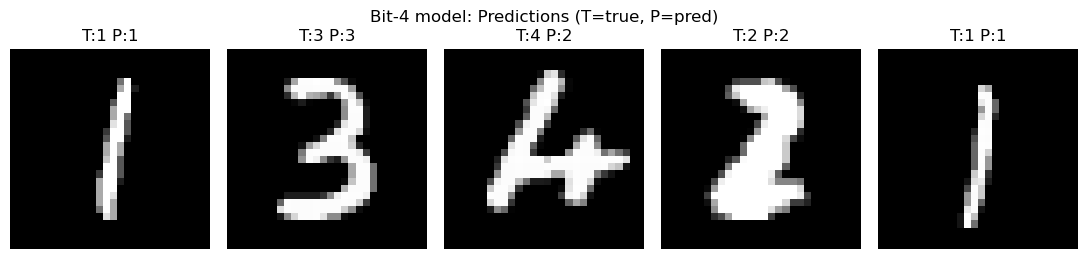

In [12]:
# Bit-4 training and plotting
res_bit4 = run_experiment('bit4', layers = [784, 32, 4], activations = ['sigmoid', None], loss = 'bce_logits')
with open('trained_mnist_model_bit4.pkl', 'wb') as f:
    pickle.dump(res_bit4['model'], f)
print("Model saved: trained_mnist_model_bit4.pkl")
print(f"Bit-4 Test Acc: {res_bit4['test_acc']:.4f}")

# Plot loss curves comparing one-hot vs bit4
try:
    plot_loss_curves_both(res_onehot, res_bit4, save_path='loss_curves_10out_vs_4bit.png')
except Exception:
    pass

# Plot prediction grid for bit4 model (images + true/pred labels)
plot_predictions_grid(res_bit4['model'], res_bit4['X_test'], res_bit4['y_test'],
                      mode_title='Bit-4 model',
                      decode_pred_fn=bit4_logits_to_int,
                      decode_true_fn=bit4_bits_to_int,
                      n=5,
                      save_path='predictions_bit4.png')


## Attack block

Run adversarial attacks (FGSM, etc.) on trained models and evaluate robustness.

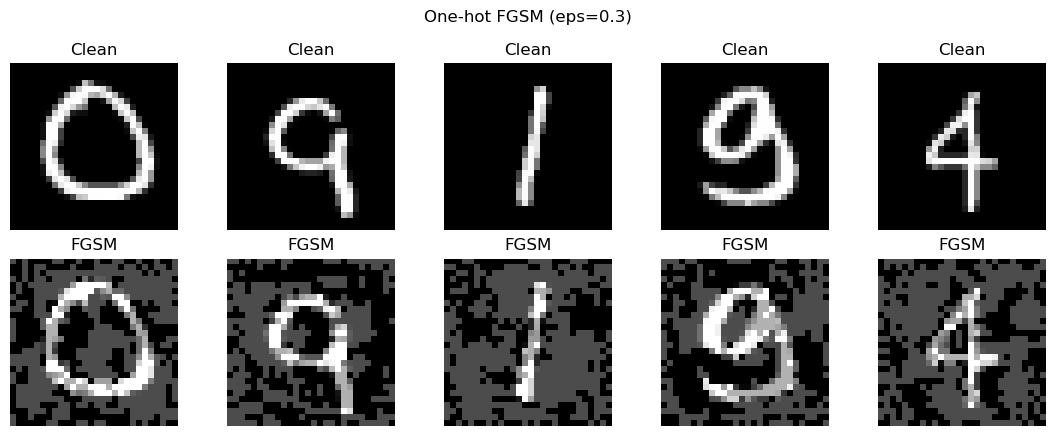


=== One-hot Attack Evaluation ===
Clean accuracy: 0.9410
Attack accuracy (eps=0.3): 0.2130


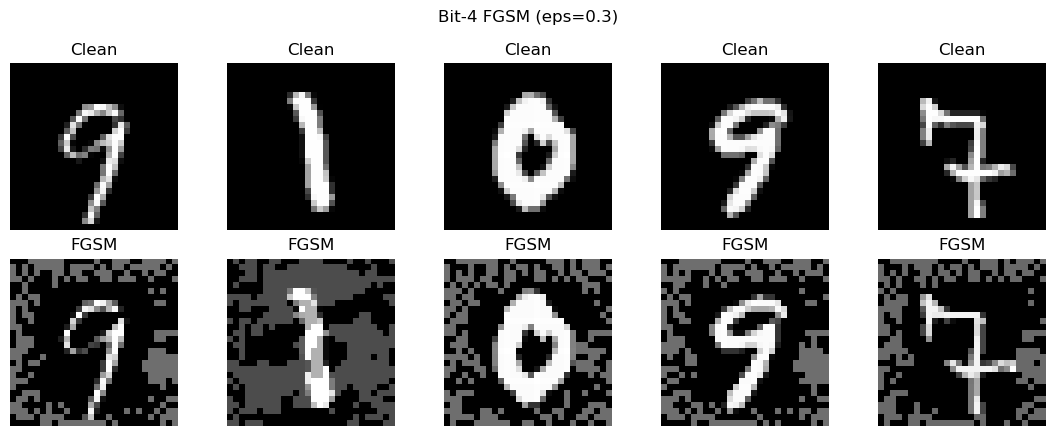


=== Bit-4 Attack Evaluation ===
Clean accuracy: 0.8403
Attack accuracy (eps=0.3): 0.4173
Epoch 1: Train Acc=0.9330, Val Acc=0.9581, Train Loss=0.0527, Val Loss=0.0362
Epoch 2: Train Acc=0.9364, Val Acc=0.9584, Train Loss=0.0490, Val Loss=0.0364
Epoch 3: Train Acc=0.9389, Val Acc=0.9588, Train Loss=0.0466, Val Loss=0.0355
Epoch 4: Train Acc=0.9391, Val Acc=0.9585, Train Loss=0.0458, Val Loss=0.0363
Epoch 5: Train Acc=0.9398, Val Acc=0.9569, Train Loss=0.0451, Val Loss=0.0364
Epoch 6: Train Acc=0.9421, Val Acc=0.9581, Train Loss=0.0431, Val Loss=0.0356
Epoch 7: Train Acc=0.9418, Val Acc=0.9581, Train Loss=0.0440, Val Loss=0.0366
Epoch 8: Train Acc=0.9438, Val Acc=0.9594, Train Loss=0.0418, Val Loss=0.0352
Epoch 9: Train Acc=0.9445, Val Acc=0.9563, Train Loss=0.0414, Val Loss=0.0362
Epoch 10: Train Acc=0.9452, Val Acc=0.9583, Train Loss=0.0410, Val Loss=0.0359
Epoch 11: Train Acc=0.9458, Val Acc=0.9578, Train Loss=0.0406, Val Loss=0.0362
Epoch 12: Train Acc=0.9471, Val Acc=0.9594, Train 

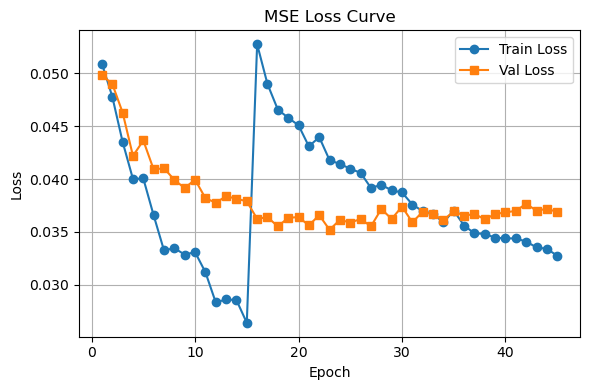

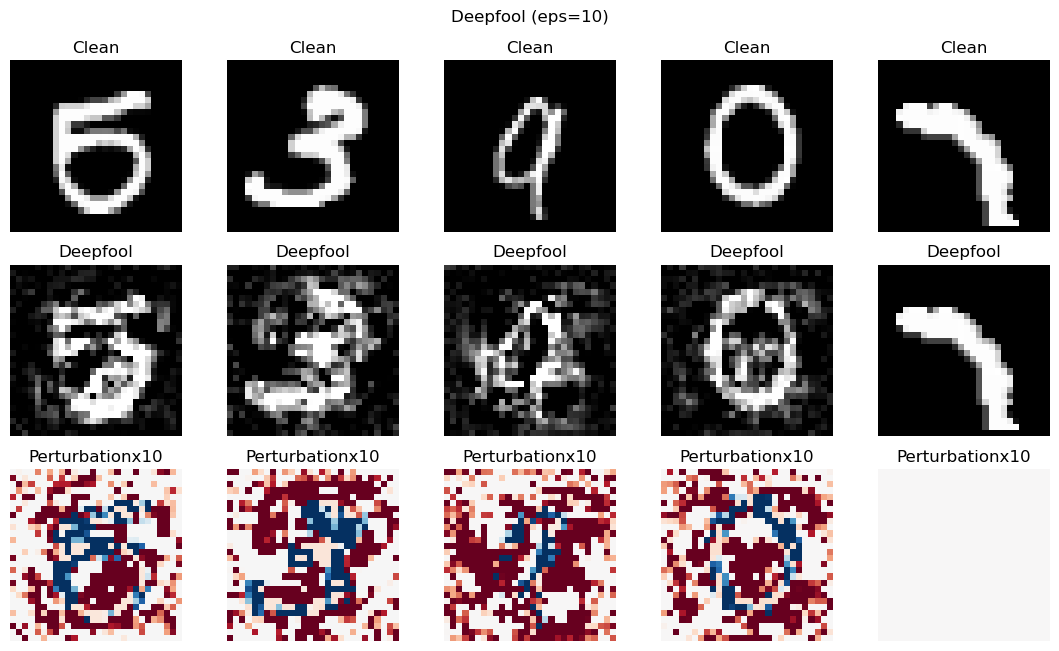


=== Original Model DeepFool Attack ===
Clean accuracy: 0.9423
Attack accuracy (eps=10): 0.5793


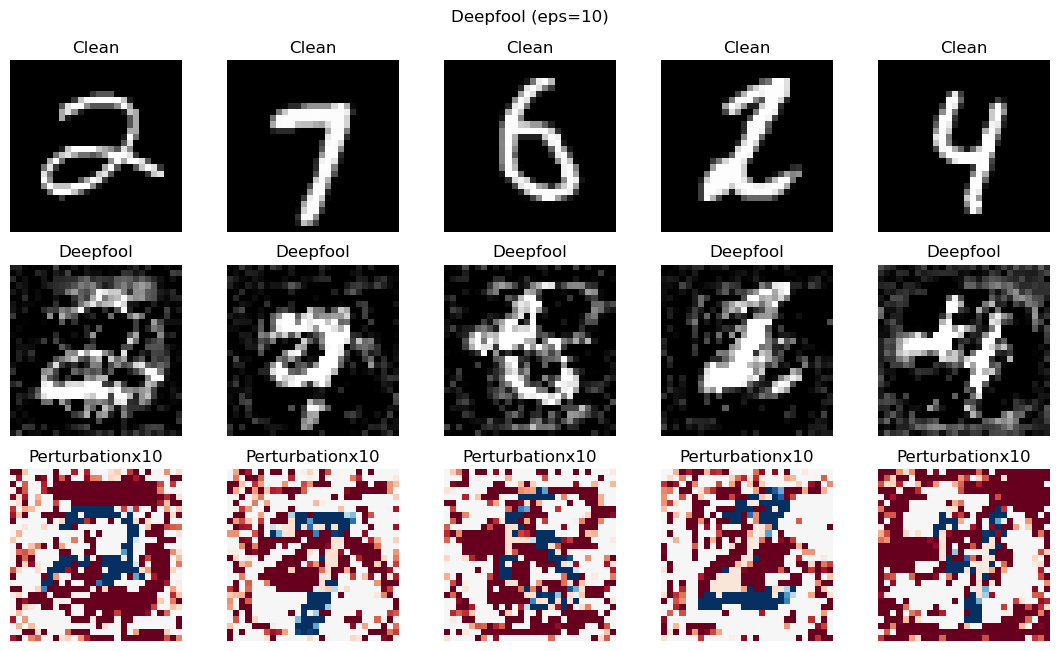


=== DeepFool Attack Evaluation ===
Clean accuracy: 0.9423
Attack accuracy (eps=10): 0.5793

Artifacts saved:
 - loss_curves_10out_vs_4bit.png
 - predictions_onehot.png
 - predictions_bit4.png
 - fgsm_onehot.png
 - fgsm_bit4.png
 - loss_curve_retrained_model.png


In [13]:
eps = 0.3
n_eval = 3000

X_eval_10 = res_onehot['X_test'][:n_eval]
Y_eval_10 = res_onehot['y_test'][:n_eval]
# FGSM attack
acc_clean_10, acc_adv_10, X_adv = plot_fgsm_comparison_grid(res_onehot['model'], X_eval_10, Y_eval_10, eps,
                                                         mode_title='One-hot', n=5,
                                                         save_path='fgsm_onehot.png')
summarize_results('One-hot Attack Evaluation', acc_clean_10, acc_adv_10, eps)

X_eval_b4 = res_bit4['X_test'][:n_eval]
Y_eval_b4 = res_bit4['y_test'][:n_eval]
acc_clean_b4, acc_adv_b4, _ = plot_fgsm_comparison_grid(
    res_bit4['model'], X_eval_b4, Y_eval_b4, eps,
    mode_title='Bit-4',
    decode_pred_fn=bit4_logits_to_int,
    decode_true_fn=bit4_bits_to_int,
    n=5,
    save_path='fgsm_bit4.png')
summarize_results('Bit-4 Attack Evaluation', acc_clean_b4, acc_adv_b4, eps)

# retrain one-hot model with FGSM adversarial examples
loaded_model = res_onehot['model']
X_mixed = np.vstack([res_onehot['X_train'], X_adv])
y_mixed = np.vstack([res_onehot['y_train'], Y_eval_10])

# shuffle data
indices = np.random.permutation(X_mixed.shape[0])
X_mixed = X_mixed[indices]
y_mixed = y_mixed[indices]

loaded_model.fit(X_mixed, y_mixed, res_onehot['X_val'], res_onehot['y_val'], epochs=30, lr=0.2, batch_size=10)
test_acc = loaded_model.evaluate(res_onehot['X_test'], res_onehot['y_test'])
    
print("\n=== Retrained Model with FGSM Adversarial Examples ===")
print("Attack Model Final Test Accuracy:", test_acc)# Generate adversarial examples using FGSM
with open('trained_mnist_attack_model.pkl', 'wb') as f:
    pickle.dump(loaded_model, f)
print("Model have been saved: trained_mnist_model.pkl")

# Plot Trining/Validation Loss Curve
plot_loss_curve(loaded_model, save_path='loss_curve_retrained_model.png') 

## New Attack with DeepFool
with open('trained_mnist_attack_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
eps_df = 10
acc_clean_orig, acc_adv_orig = plot_df_grid(res_onehot['model'], X_eval_10, Y_eval_10, eps_df, n=5,
                                             save_path='df_original.png')
summarize_results('Original Model DeepFool Attack', acc_clean_orig, acc_adv_orig, eps_df)

acc_clean_df, acc_adv_df = plot_df_grid(loaded_model, X_eval_10, Y_eval_10, eps_df, n=5,
                                                         save_path='df_onehot.png')
summarize_results('DeepFool Attack Evaluation', acc_clean_df, acc_adv_df, eps_df)
 
print("\nArtifacts saved:")
print(" - loss_curves_10out_vs_4bit.png")
print(" - predictions_onehot.png")
print(" - predictions_bit4.png")
print(" - fgsm_onehot.png")
print(" - fgsm_bit4.png")
print(" - loss_curve_retrained_model.png")


---
**Notes:**
- The notebook depends on `Visualization.py` and `Functions.py` in the same directory.
- `mnist.pkl.gz` should also be available in the working directory.
- The main workflow is divided into three blocks: One-hot, Bit-4, and Attack.
